## Importing

In [1]:
from __future__ import print_function
%load_ext autoreload
%autoreload 2
import time, os
from IPython import display

from pixell import enmap,utils as putils,reproject,enplot
from pixell.lensing import phi_to_kappa
from pixell.reproject import healpix2map,thumbnails
from pixell.curvedsky import alm2map,map2alm,almxfl
from pixell.pointsrcs import radial_bin

import numpy as np
import matplotlib.pyplot as plt

import healpy as hp
from healpy.fitsfunc import read_alm,read_map

import symlens as s
from symlens import utils as sutils

# utils require orphics + pyfisher + enlib
from falafel import qe, utils as futils
import pytempura 

from orphics import maps, cosmology, io, stats, pixcov

# my own file
import websky_stack_and_visualize as josh_websky

plt.rcParams['figure.facecolor'] = 'white'

## Opening / preparing sims

In [2]:
PATH_TO_FALAFEL = "/home/joshua/research/falafel"
config = io.config_from_yaml(PATH_TO_FALAFEL + "/input/config.yml")
thloc = PATH_TO_FALAFEL + "/data/" + config['theory_root']
theory = cosmology.loadTheorySpectraFromCAMB(thloc,get_dimensionless=False)

# simulated maps file location
alm_filename = "../lensed_alm.fits"
alm_hp = read_alm(alm_filename)

# 0.5 (1.5 for now) arcmin resolution car geometry
shape, wcs = enmap.fullsky_geometry(res=np.deg2rad(1.5 / 60.))
# create empty map to overlay our map
omap = enmap.empty(shape, wcs, dtype=np.float32)
alm_px = alm2map(alm_hp, omap)

In [3]:
LMIN = 300
LMAX = 6000
ests = ['TT']

alms = map2alm(alm_px, lmax=LMAX)
beam_fwhm = 1.5 # arcmin
noise_t = 10. # noise stdev in uK-arcmin
# ucls['TT'] = C_ell_TT, tcls['TT'] = C_ell_TT + N_ell_TT 
ucls, tcls = futils.get_theory_dicts_white_noise(beam_fwhm, noise_t)

fTalm = futils.isotropic_filter([alms, alms*0., alms*0.],
                                 tcls, LMIN, LMAX, ignore_te=True)[0]

# lensing convergence file
kap_filename = "kap.fits"
RES = np.deg2rad(1.0 / 60.)
kap_px = josh_websky.px_to_car("../" + kap_filename, res=RES)
# filter to LMAX
kap_map = alm2map(map2alm(kap_px, lmax=LMAX), enmap.empty(shape, wcs, dtype=np.float32))

## Falafel lensing reconstruction

In [4]:
px = qe.pixelization(shape=shape, wcs=wcs)

recon_alms = qe.qe_all(px, ucls, fTalm=fTalm, fEalm=fTalm*0., fBalm=fTalm*0.,
                       mlmax=LMAX, estimators=ests)

# actually unneeded
recon_map = alm2map(phi_to_kappa(recon_alms['TT'][0].astype(np.complex128)),
                    enmap.empty(shape, wcs, dtype=np.float32))

## Tempura reconstruction normalization

In [5]:
# first index for the gradient
t_norms = pytempura.get_norms(ests, ucls, tcls, LMIN, LMAX, k_ellmax=LMAX, no_corr=False)

# create tempura normalized map
kappa_alms = phi_to_kappa(almxfl(recon_alms['TT'][0].astype(np.complex128),
                                 t_norms['TT'][0]))

kappa_map = alm2map(kappa_alms, enmap.empty(shape, wcs, dtype=np.float32))

## Symlens reconstruction normalization

In [6]:
SYM_LMIN = 300
SYM_LMAX = 6000
SYM_GLMIN = 300
SYM_GLMAX = 2000

sym_shape, sym_wcs = enmap.geometry(res=1.5 * putils.arcmin,pos=[0,0],shape=(2000,2000), proj='plain') 

kmask = sutils.mask_kspace(sym_shape, sym_wcs, lmin=SYM_LMIN, lmax=SYM_LMAX)
g_kmask = sutils.mask_kspace(sym_shape, sym_wcs, lmin=SYM_GLMIN, lmax=SYM_LMAX)
g_cut_kmask = sutils.mask_kspace(sym_shape, sym_wcs, lmin=SYM_GLMIN, lmax=SYM_GLMAX)
# g_kmasker = lambda l: sutils.mask_kspace(sym_shape, sym_wcs, lmin=SYM_GLMIN, lmax=l)

# generate a feed_dict
feed_dict = {}
feed_dict_grad = {}
NOISE_T = noise_t
BEAM_FWHM = beam_fwhm # arcmin?
modlmap = enmap.modlmap(sym_shape, sym_wcs)

# from falafel/utils.py
ells,gt,ge,gb,gte = np.loadtxt(f"{thloc}_camb_1.0.12_grads.dat",unpack=True,usecols=[0,1,2,3,4])
nells = (NOISE_T*np.pi/180./60.)**2. / sutils.gauss_beam(BEAM_FWHM,modlmap)**2.

#feed_dict_grad['uC_T_T'] = sutils.interp(ells, gt)(modlmap)
#feed_dict_grad['tC_T_T'] = feed_dict_grad['uC_T_T'] + nells
feed_dict['uC_T_T'] = theory.lCl('TT',modlmap)
feed_dict['tC_T_T'] = feed_dict['uC_T_T'] + nells

# generate normalization
s_norms = s.A_l(sym_shape,sym_wcs,feed_dict,"hdv","TT",xmask=g_kmask,ymask=kmask)
new_s_norms = s.A_l(sym_shape,sym_wcs,feed_dict,"hdv","TT",xmask=g_cut_kmask,ymask=kmask)

## Radial binning functions

In [7]:
# works for rectangles too!
# returns map where values represent arcmin distance from the center of the map
def distance_map(imap, res):
    [xdim, ydim] = imap.shape
    xvec, yvec = np.ones(xdim), np.ones(ydim)
    # create an array of size N, centered at 0 and incremented by pixel count
    xinds, yinds = (np.arange(xdim) + 0.5 - xdim/2.), (np.arange(ydim) + 0.5 - ydim/2.)
    # compute the outer product matrix: X[i, j] = onesvec[i] * inds[j] for i,j 
    # in range(N), which is just N rows copies of inds - for the x dimension
    x = np.outer(xvec, yinds)
    y = np.outer(xinds, yvec)
    r = np.sqrt(x**2 + y**2)
    
    return r * res

# gonna write my own function
def radial_sum_own(imap, res, bins, weights=None):
    dmap = distance_map(imap, res)
    if weights is not None: imap = imap * weights
    result = []
    
    for in_bin, out_bin in zip(bins, bins[1:]):
        # indices
        (xcoords, ycoords) = np.where(np.logical_and(dmap >= in_bin, dmap < out_bin))
        coords = [(xcoords[i], ycoords[i]) for i in range(len(xcoords))]
        # sum of values within the annulus of distance
        result.append(sum([imap[x,y] for (x,y) in coords]))
        
    return result

def radial_lsum_own(imap, shape, wcs, bins, weights=None):
    dmap = enmap.modlmap(shape, wcs)
    if weights is not None: imap = imap * weights
    result = []
    
    for in_bin, out_bin in zip(bins, bins[1:]):
        # indices
        (xcoords, ycoords) = np.where(np.logical_and(dmap >= in_bin, dmap < out_bin))
        coords = [(xcoords[i], ycoords[i]) for i in range(len(xcoords))]
        # sum of values within the annulus of distance
        result.append(sum([imap[x,y] for (x,y) in coords]))
        
    return result

def radial_avg_own(imap, res, bins, weights=None):
    
    numerator = radial_sum_own(imap, res, bins, weights)
    map_ones = 1. + enmap.empty(imap.shape, imap.wcs, dtype=np.float32)
    denominator = radial_sum_own(map_ones, res, bins, None)
    assert len(numerator) == len(denominator), "unequal sizes of numerator + denominator for averaging"
    
    return [numerator[i] / denominator[i] for i in range(len(numerator))]

def radial_avg2_own(imap, res, bins, weights=None):
    dmap = distance_map(imap, res)
    if weights is not None: imap = imap * weights
    result = []
    
    for in_bin, out_bin in zip(bins, bins[1:]):
        # indices
        (xcoords, ycoords) = np.where(np.logical_and(dmap >= in_bin, dmap < out_bin))
        coords = [(xcoords[i], ycoords[i]) for i in range(len(xcoords))]
        # sum of values within the annulus of distance
        result.append(sum([imap[x,y] for (x,y) in coords]) / len(coords))
        
    return result

# aggregate values in L into a new list of Nnew indices
def listcollector(L, Nnew):
    result = []
    agg_size = len(L) // Nnew
    for i in range(Nnew):
        result.append(sum(L[i*agg_size:(i+1)*agg_size]))
    return result

## Verifying binning results

In [22]:
# indices
kells = np.arange(t_norms['TT'][0].shape[0])

# binning setup
Lwidth = 50
Lrange = np.arange(LMIN,LMAX,Lwidth)
binner = stats.bin2D(modlmap, Lrange)

# bin symless
l_factor = modlmap * (modlmap + 1) / 4.
centers, binned_s_norms = binner.bin(s_norms)
# just to see if factoring in the l's before binning will make a difference
_, binned_s_norms2 = binner.bin(s_norms * l_factor)
# interpolate symlens norms for tempura format
Al_sym = maps.interp(centers, binned_s_norms, kind='cubic')(kells) * kells * (kells + 1) / 4.
# Al_sym = maps.interp(centers, binned_s_norms, kind='cubic')(kells) / (kells * (kells + 1))
Al_sym2 = maps.interp(centers, binned_s_norms2, kind='cubic')(kells)
Al_temp = t_norms['TT'][0] * (kells * (kells + 1) / 2.)**2
#Al_temp = t_norms['TT'][0]

In [ ]:
# gradient cut symlens


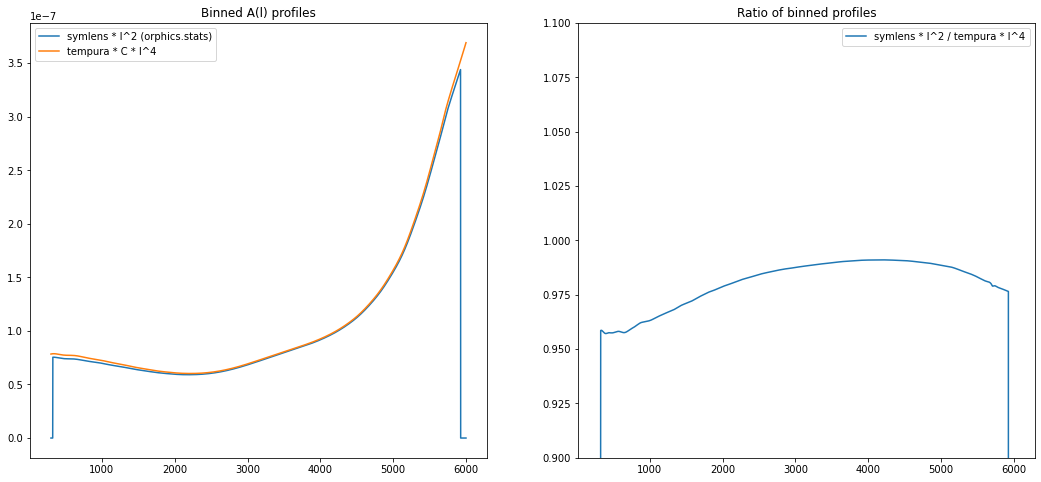

In [23]:
# plot symlens * l^2 vs tempura * l^4
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,8))

axes[0].set_title("Binned A(l) profiles")
axes[0].plot(kells[LMIN:LMAX+1], Al_sym[LMIN:LMAX+1], label="symlens * l^2 (orphics.stats)")
#plt.plot(kells[LMIN:LMAX+1], Al_sym2[LMIN:LMAX+1], label="symlens * l^2 (l^2 bins)")
axes[0].plot(kells[LMIN:LMAX+1], Al_temp[LMIN:LMAX+1], label="tempura * C * l^4")
axes[0].legend()

axes[1].set_title("Ratio of binned profiles")
axes[1].set_ylim(0.9,1.1)
axes[1].plot(kells[LMIN:LMAX+1], Al_sym[LMIN:LMAX+1] / Al_temp[LMIN:LMAX+1], label="symlens * l^2 / tempura * l^4")
axes[1].legend()

plt.savefig("binned-als-new-plus-deltas.png")
plt.show()

/tmp/ipykernel_2921/3953631793.py:8: RuntimeWarning: invalid value encountered in true_divide
  axes[1].plot(kells[LMIN:LMAX+1], Al_sym[LMIN:LMAX+1] / Al_sym2[LMIN:LMAX+1],


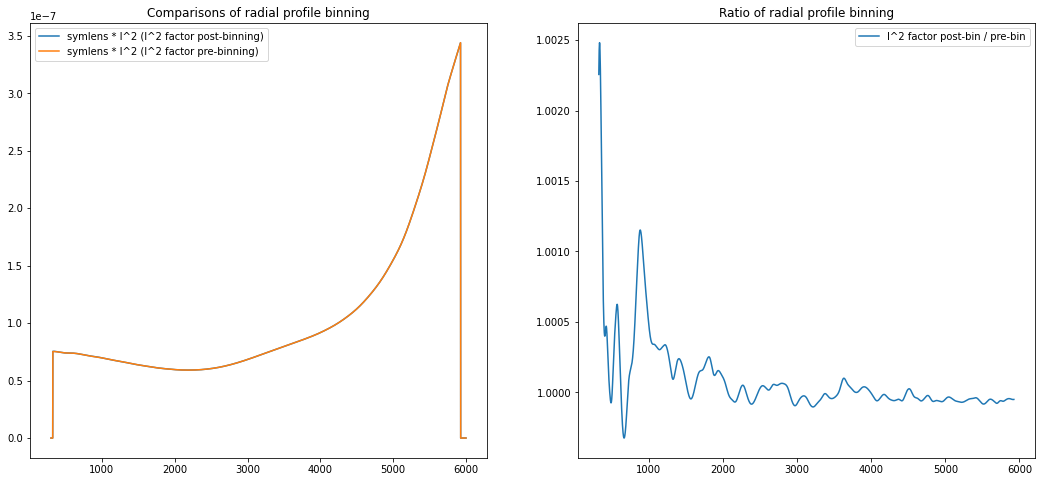

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
axes[0].set_title("Comparisons of radial profile binning")
axes[0].plot(kells[LMIN:LMAX+1], Al_sym[LMIN:LMAX+1], label="symlens * l^2 (l^2 factor post-binning)")
axes[0].plot(kells[LMIN:LMAX+1], Al_sym2[LMIN:LMAX+1], label="symlens * l^2 (l^2 factor pre-binning)")
axes[0].legend()

axes[1].set_title("Ratio of radial profile binning")
axes[1].plot(kells[LMIN:LMAX+1], Al_sym[LMIN:LMAX+1] / Al_sym2[LMIN:LMAX+1],
            label="l^2 factor post-bin / pre-bin")
axes[1].legend()
plt.savefig("comparing-radial-profile-binning.png")

## Plotting stacked kappa maps

In [18]:
# generating maps by performing A_l * phi and converting to kappa
mapper = lambda norms: alm2map(phi_to_kappa(almxfl(recon_alms['TT'][0].astype(np.complex128),
                                                   np.array([0. if (i < LMIN or i > LMAX) else norms[i] 
                                                             for i in range(len(norms))]))),
                               enmap.empty(shape, wcs, dtype=np.float32))

symlens_map = mapper(Al_sym / (kells * (kells + 1) / 2.)**2)
tempura_map = mapper(Al_temp / (kells * (kells + 1) / 2.)**2)

/tmp/ipykernel_2921/851154664.py:7: RuntimeWarning: invalid value encountered in true_divide
  symlens_map = mapper(Al_sym / (kells * (kells + 1) / 2.)**2)
/tmp/ipykernel_2921/851154664.py:8: RuntimeWarning: invalid value encountered in true_divide
  tempura_map = mapper(Al_temp / (kells * (kells + 1) / 2.)**2)


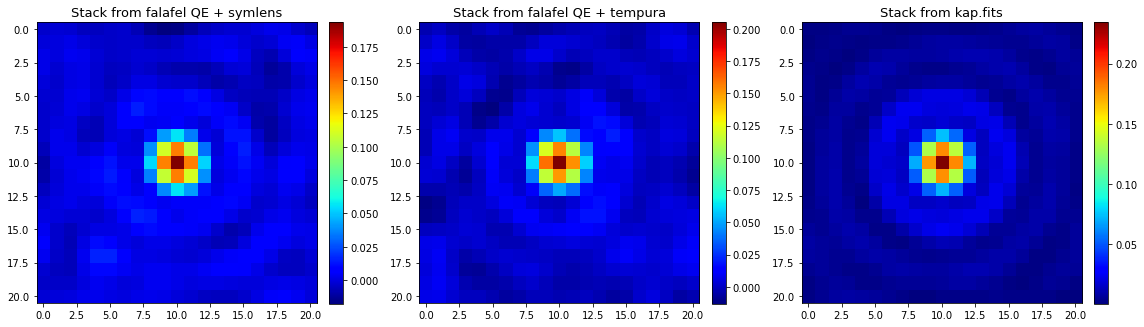

In [24]:
full_ra, full_dec = josh_websky.read_coords_from_file("1e6_massive_halos.txt")
NCOORDS = 3000
RES = np.deg2rad(1.0 / 60.)

# stack QE recon'd maps 
stack_map, avg_s_map = josh_websky.stack_average_random(symlens_map, full_ra, full_dec, Ncoords=NCOORDS,
                                                      radius=10*RES, res=RES)

# stack kap.fits convergence map
stack_kap, avg_kap = josh_websky.stack_average_random(kap_map, full_ra, full_dec, Ncoords=NCOORDS,
                                                      radius=10*RES, res=RES)           

stack_s_map, avg_t_map = josh_websky.stack_average_random(tempura_map, full_ra, full_dec, Ncoords=NCOORDS,
                                                          radius=10*RES, res=RES)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,36))

im1 = axes[0].imshow(avg_s_map, cmap='jet')
axes[0].set_title("Stack from falafel QE + symlens", fontsize=13)
im2 = axes[1].imshow(avg_t_map, cmap='jet')
axes[1].set_title("Stack from falafel QE + tempura", fontsize=13)
im3 = axes[2].imshow(avg_kap, cmap='jet')
axes[2].set_title("Stack from kap.fits", fontsize=13)

fig.subplots_adjust(right=0.85)
fig.colorbar(im1, ax = axes[0], fraction=0.046, pad=0.04)
fig.colorbar(im2, ax = axes[1], fraction=0.046, pad=0.04)
fig.colorbar(im3, ax = axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig("full-data-stacks.png")
plt.show()

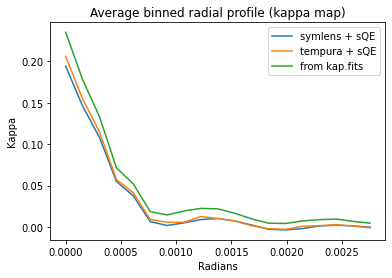

In [25]:
res = np.deg2rad(1.0 / 60.)
N = 20
res_range = np.linspace(0, 10 * res, N)
binned_kap = radial_avg2_own(avg_kap, res, res_range)
binned_tkap = radial_avg2_own(avg_t_map, res, res_range)
binned_skap = radial_avg2_own(avg_s_map, res, res_range)

plt.title("Average binned radial profile (kappa map)")
plt.xlabel("Radians")
plt.ylabel("Kappa")
plt.plot(res_range[:-1], binned_skap, label="symlens + sQE")
plt.plot(res_range[:-1], binned_tkap, label="tempura + sQE")
plt.plot(res_range[:-1], binned_kap, label="from kap.fits")
plt.legend()
plt.savefig("kappa-binned-radial-profiles.png")